In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1

In [3]:
df = pd.read_pickle("/content/drive/Shareddrives/TNT/정규세션/2021년 2학기/산업인공지능/TASK2-wafer map /LSWMD.pkl")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


### EDA 

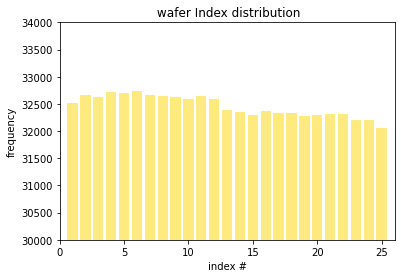

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [5]:
df = df.drop(['waferIndex'], axis = 1)

In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
709529,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43407,[[Training]],[[none]],"(25, 27)"
31818,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7874.0,lot3112,[],[],"(118, 84)"
453755,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot27860,[],[],"(31, 31)"
29128,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot2981,[],[],"(33, 29)"
291395,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2367.0,lot17866,[],[],"(51, 59)"


watermapdim이 (26,26)만 남도록 하거나, resize함수 이용해서 다 resize하여 task 진행




In [7]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [8]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [9]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


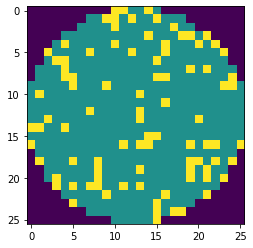

Faulty case : ['none'] 


In [10]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [11]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [12]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [13]:
faulty_case_dict =dict()

In [14]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y[y==f])))
    faulty_case_dict[i] = f

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


이미지 채널 쪼개서 원핫인코딩


In [15]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [16]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

## train / test image 분류

+  간단한 augmentation 수행
-> torchvision.transforms
-> torchvision.datasets.Imagefolder
-> keras.preprocessing.image.ImageDataGenerator

- https://albumentations.ai/docs/examples/tensorflow-example/

In [17]:
x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.2, random_state=25)

In [18]:
# train = 0.8 * 0.75 = 0.6 
# val = 0.25 * 0.8 = 0.2
# test = 0.2

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 1) 


In [19]:
y_train

array([['none'],
       ['none'],
       ['none'],
       ...,
       ['none'],
       ['none'],
       ['none']], dtype='<U9')

In [20]:
faulty_case_dict_train =dict()

In [21]:
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_train[y_train==f])))
    faulty_case_dict_train[i] = f

Center : 59
Donut : 0
Edge-Loc : 181
Edge-Ring : 18
Loc : 168
Near-full : 9
Random : 46
Scratch : 47
none : 8091


In [22]:
faulty_case_dict_valid =dict()
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_val[y_val==f])))
    faulty_case_dict_train[i] = f

Center : 13
Donut : 0
Edge-Loc : 50
Edge-Ring : 8
Loc : 56
Near-full : 4
Random : 16
Scratch : 12
none : 2714


### test를 제외한 train, valid data는 많이 늘려야 한다. + 도넛을 찾아서 넣어줘야 함... 일단 제외?

In [23]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 102 kB 6.4 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
albumentations==1.1.0 is successfully installed


In [24]:
from functools import partial
from albumentations import (
    Compose, HorizontalFlip, RandomRotate90, GaussNoise, VerticalFlip, ToFloat
)

In [25]:
transforms = Compose([
            RandomRotate90(p=0.9),
            HorizontalFlip(p=0.5),
            # # GaussNoise(),
            VerticalFlip(p=0.6),
            # ToFloat(max_value=255)
        ])

In [26]:
from tensorflow.python.keras.utils.data_utils import Sequence

class DataSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([
            self.augment(image=x)["image"] for x in batch_x], axis=0), np.array(batch_y)

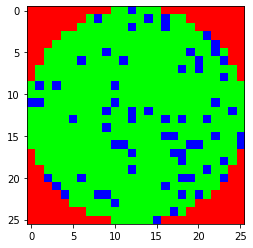

In [27]:
# 원래 데이터
plt.imshow(x_train[0])
plt.show()

In [28]:
batch_size = 1
trans_train_dataset = DataSequence(x_train, y_train, batch_size, transforms)
images, labels = next(iter(trans_train_dataset))

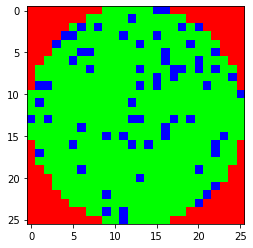

In [29]:
plt.imshow(images[0])
plt.show()

In [30]:
# Augmentation for all faulty case.
batch_size = 1
for i in range(3):
    for f in faulty_case : 
    # skip none case
        if f == 'none' or f == 'Donut' : 
            continue
        Datasets = DataSequence(x_train[np.where(y_train==f)[0]], y_train[np.where(y_train==f)[0]], batch_size, transforms)
        gen_x, gen_y = next(iter(Datasets))
        x_train = np.concatenate((x_train, gen_x), axis=0)
        y_train = np.concatenate((y_train, gen_y))

In [31]:
faulty_case_dict_valid =dict()
for i, f in enumerate(faulty_case) :
    print('{} : {}'.format(f, len(y_train[y_train==f])))
    faulty_case_dict_train[i] = f

Center : 62
Donut : 0
Edge-Loc : 184
Edge-Ring : 21
Loc : 171
Near-full : 12
Random : 49
Scratch : 50
none : 8091


In [32]:
y_train.shape

(8640, 1)

In [33]:
x_train.shape

(8640, 26, 26, 3)

In [34]:
len(y_train[y_train=='Center'])

62

## Convolutional Autoencoder for augmentation.
불균형 문제를 해결할 필요성을 확인함. <br>
이미지 데이터인 wafermap을 convolution AE를 활용해 해결시도

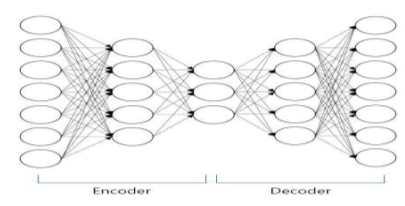

In [35]:
# parameter
epoch= 10
batch_size=512
  
# callbacks = keras.callbacks.EarlyStopping(monitor='loss', mode= 'min', baseline = 0.001, patience = 5 )
# class MyThresholdCallback(tf.keras.callbacks.Callback):
#     def __init__(self, threshold):
#         super(MyThresholdCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None): 
#         accuracy = logs["acc"]
#         if accuracy >= self.threshold:
#             self.model.stop_training = True
# callbacks = MyThresholdCallback(threshold = 0.9)

In [36]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu') #복원
decode_layer_2 = layers.UpSampling2D() # 크기를 늘림
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid') # 다시 3채널 만들기

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

Check summary

In [37]:
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 13, 13, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 3)         1731      
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________

In [38]:
# start train
ae.fit(x_train, x_train,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/10
17/17 - 20s - loss: 0.1526
Epoch 2/10
17/17 - 19s - loss: 0.0899
Epoch 3/10
17/17 - 19s - loss: 0.0774
Epoch 4/10
17/17 - 19s - loss: 0.0680
Epoch 5/10
17/17 - 19s - loss: 0.0615
Epoch 6/10
17/17 - 19s - loss: 0.0558
Epoch 7/10
17/17 - 19s - loss: 0.0508
Epoch 8/10
17/17 - 19s - loss: 0.0463
Epoch 9/10
17/17 - 19s - loss: 0.0416
Epoch 10/10
17/17 - 19s - loss: 0.0367


In [39]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [40]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [41]:
# Encode original faulty wafer
encoded_x = encoder.predict(x_train)

In [42]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

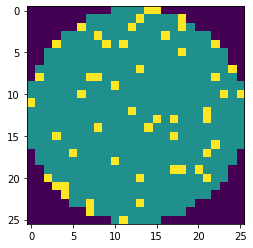

In [43]:
# check original faulty wafer data
plt.imshow(np.argmax(x_train[3], axis=2))

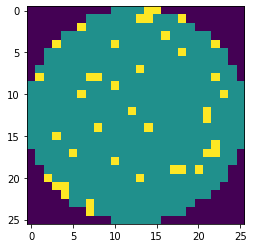

In [44]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

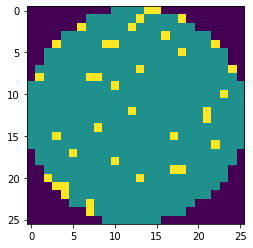

In [45]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(x_train), axis=3)
plt.imshow(gen_x[3])

# New_autoencoder

In [ ]:
# tensorflow tutorial
"""
    기존의 Autoencoder는 encoder를 위해, VAE 는 Decoder를 위해
    https://www.youtube.com/watch?v=GbCAwVVKaHY

    encoder output이 두개 의 vector : 평균, 표준편차 -> normal distribution -> z sampling(미분가능한 식으로) -> decoder -> output 복원

    학습 함수 : reconstruction error - cross entropy, regularization -> KL divergence 
"""


class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    # 
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(26, 26, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, 0])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
x_val.shape

(2873, 26, 26, 3)

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for valid_batch in x_val:
  test_sample = valid_batch[ :, :, :]

In [ ]:
test_sample.shape

(26, 26, 3)

In [ ]:
x_val[:15].shape

(15, 26, 26, 3)

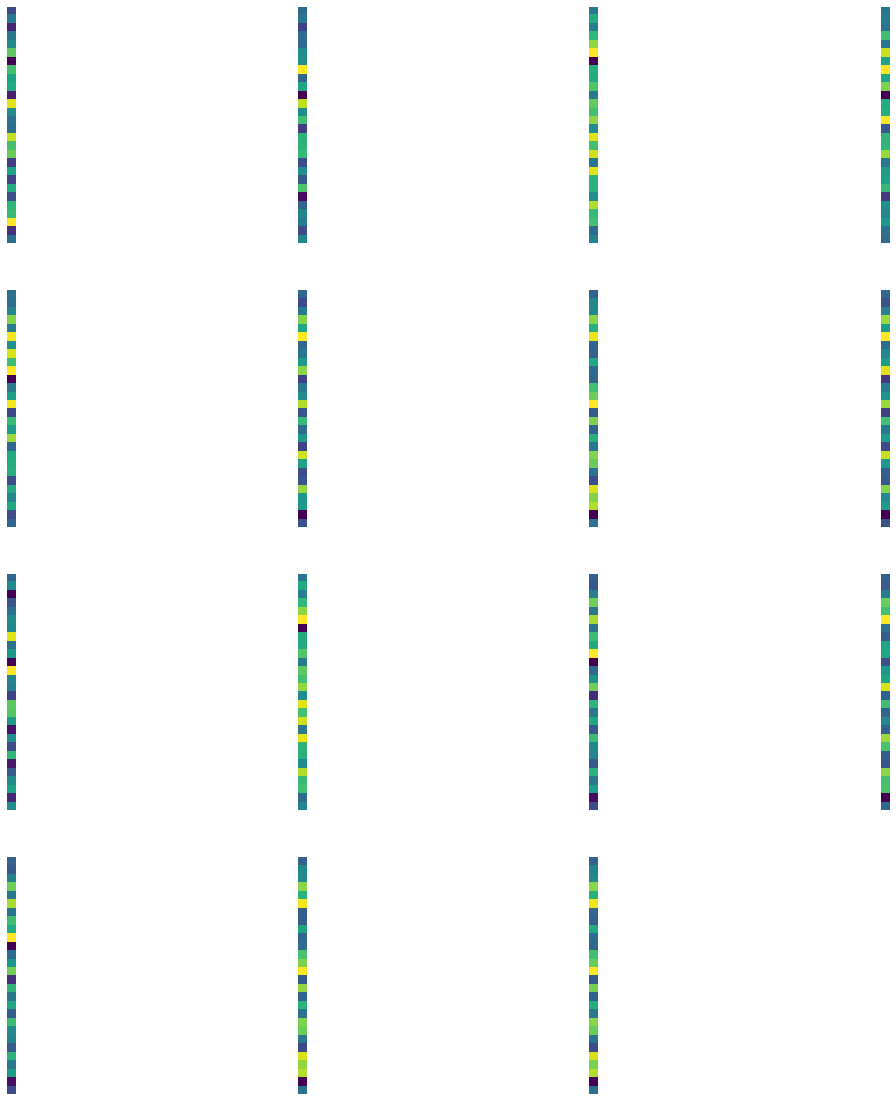

In [ ]:
import time
generate_and_save_images(model, epoch, x_val[:15])

## Data augmentation


In [46]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [47]:
# Augmentation for all faulty case.
# for f in faulty_case : 
#     # skip none case
#     if f == 'none' or f =='Donut':
#         continue
faulty_case_train = ['Center', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
for f in faulty_case_train:
    print(f)

Center
Edge-Loc
Edge-Ring
Loc
Near-full
Random
Scratch


In [48]:
y_train[y_train=='Center'][0]

'Center'

In [53]:
# 2번 돌림
for f in faulty_case_train:
    print(f)
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], y_train[y_train==f][0])
    
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

Center
Edge-Loc
Edge-Ring
Loc
Near-full
Random
Scratch


In [50]:
faulty_case

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype='<U9')

In [54]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new_x shape : (37591, 26, 26, 3), new_y shape : (37591, 1)


In [55]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Center : 4216
Donut : 0
Edge-Loc : 4416
Edge-Ring : 4074
Loc : 4446
Near-full : 4032
Random : 4116
Scratch : 4200
none : 8091


In [56]:
# choice index without replace.
none_idx = np.where(y_train=='none')[0][np.random.choice(len(np.where(y_train=='none')[0]), size=4000, replace=False)]

In [57]:
# delete choiced index data.
x_train = np.delete(x_train, none_idx, axis=0)
y_train = np.delete(y_train, none_idx, axis=0)

In [58]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(x_train.shape, y_train.shape))

After Delete "none" class new_x shape : (33591, 26, 26, 3), new_y shape : (33591, 1)


In [59]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y_train[y_train==f])))

Center : 4216
Donut : 0
Edge-Loc : 4416
Edge-Ring : 4074
Loc : 4446
Near-full : 4032
Random : 4116
Scratch : 4200
none : 4091


In [60]:
from tensorflow.keras.utils import to_categorical
for i, l in enumerate(faulty_case):
    y_train[y_train==l] = i
    
y_train = to_categorical(y_train)# to_categorical : y 가 label이 0-9있으면 이걸 다 원핫인코딩으로 표현

In [65]:
for i, l in enumerate(faulty_case):
    y_val[y_val==l] = i
    
y_val = to_categorical(y_val)# to_categorical : y 가 label이 0-9있으면 이걸 다 원핫인코딩으로 표현

In [66]:
for i, l in enumerate(faulty_case):
    y_test[y_test==l] = i
    
y_test = to_categorical(y_test)# to_categorical : y 가 label이 0-9있으면 이걸 다 원핫인코딩으로 표현

### 모델 생성

In [ ]:
# input_shape = (26, 26, 3)
# input_tensor = Input(input_shape)

# def create_model():
#     input_shape = (26, 26, 3)
#     input_tensor = Input(input_shape)

#     conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
#     conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
#     conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

#     flat = layers.Flatten()(conv_3)

#     dense_1 = layers.Dense(512, activation='relu')(flat)
#     dense_2 = layers.Dense(128, activation='relu')(dense_1)
#     output_tensor = layers.Dense(9, activation='softmax')(dense_2)

#     model = models.Model(input_tensor, output_tensor)
#     model.compile(optimizer='Adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

#     return model

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
callbacks = [
             EarlyStopping(monitor='val_loss',min_delta=0,  patience=5, mode='min', restore_best_weights=True, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode = 'min', min_lr=0.001, cooldown = 5)
]

In [79]:
def my_model():
    input_shape = (26,26,3)
    input_tensor = Input(input_shape)

    conv1 = layers.Conv2D(16, (3,3), padding= 'same')(input_tensor) # 경계강화
    max1 = layers.MaxPool2D((2,2))(conv1)
    acti1 = layers.LeakyReLU()(max1)

    conv2 = layers.Conv2D(32, (3,3), padding='same')(acti1)
    max2 = layers.MaxPool2D((2,2))(conv2)
    acti2 = layers.LeakyReLU()(max2)

    conv3 = layers.Conv2D(64, (3,3), padding='same')(acti2)
    max3 = layers.MaxPool2D((2,2))(conv3)
    acti3 = layers.LeakyReLU()(max3)

    flat = layers.Flatten()(acti3)
    dens1 = layers.Dense(128, activation = 'relu', kernel_initializer= 'he_normal',kernel_regularizer=keras.regularizers.l2(0.001))(flat)
    dp1 = layers.Dropout(0.5)(dens1)
    dens2 = layers.Dense(64, activation = 'relu', kernel_initializer= 'he_normal', kernel_regularizer=keras.regularizers.l2(0.001),)(dp1)
    dp2 = layers.Dropout(0.5)(dens2)
    output = layers.Dense(9, activation='softmax')(dp2)

    model = models.Model(input_tensor, output)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [80]:
mymodel = my_model()
mymodel.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 32)          0   

In [81]:
y_train.shape

(33591, 9)

In [82]:
y_val.shape

(2873, 9)

In [83]:
x_train.shape

(33591, 26, 26, 3)

In [84]:
x_val.shape

(2873, 26, 26, 3)

In [85]:
mymodel_hist = mymodel.fit(x_train, y_train,epochs = 40, verbose =2, callbacks= callbacks, validation_data=(x_val, y_val), batch_size = 1024, )

Epoch 1/40
33/33 - 21s - loss: 2.0969 - accuracy: 0.3287 - val_loss: 0.8136 - val_accuracy: 0.9509
Epoch 2/40
33/33 - 20s - loss: 1.3820 - accuracy: 0.5870 - val_loss: 0.4618 - val_accuracy: 0.9534
Epoch 3/40
33/33 - 20s - loss: 1.0282 - accuracy: 0.7000 - val_loss: 0.3617 - val_accuracy: 0.9610
Epoch 4/40
33/33 - 20s - loss: 0.8125 - accuracy: 0.7783 - val_loss: 0.3324 - val_accuracy: 0.9641
Epoch 5/40
33/33 - 20s - loss: 0.6688 - accuracy: 0.8300 - val_loss: 0.3207 - val_accuracy: 0.9680
Epoch 6/40
33/33 - 20s - loss: 0.5676 - accuracy: 0.8647 - val_loss: 0.2927 - val_accuracy: 0.9697
Epoch 7/40
33/33 - 20s - loss: 0.4879 - accuracy: 0.8919 - val_loss: 0.2756 - val_accuracy: 0.9725
Epoch 8/40
33/33 - 20s - loss: 0.4177 - accuracy: 0.9149 - val_loss: 0.2798 - val_accuracy: 0.9708
Epoch 9/40
33/33 - 20s - loss: 0.3663 - accuracy: 0.9312 - val_loss: 0.2655 - val_accuracy: 0.9690
Epoch 10/40
33/33 - 20s - loss: 0.3275 - accuracy: 0.9445 - val_loss: 0.2624 - val_accuracy: 0.9722
Epoch 11/

In [86]:
def my_model_withoutMax():
    input_shape = (26,26,3)
    input_tensor = Input(input_shape)

    conv1 = layers.Conv2D(16, (3,3), padding= 'same')(input_tensor) # 경계강화
    
    acti1 = layers.LeakyReLU()(conv1)

    conv2 = layers.Conv2D(32, (3,3), padding='same')(acti1)

    acti2 = layers.LeakyReLU()(conv2)

    conv3 = layers.Conv2D(64, (3,3), padding='same')(acti2)

    acti3 = layers.LeakyReLU()(conv3)

    flat = layers.Flatten()(acti3)
    dens1 = layers.Dense(128, activation = 'relu', kernel_initializer= 'he_normal',kernel_regularizer=keras.regularizers.l2(0.001))(flat)
    dp1 = layers.Dropout(0.5)(dens1)
    dens2 = layers.Dense(64, activation = 'relu', kernel_initializer= 'he_normal',kernel_regularizer=keras.regularizers.l2(0.001))(dp1)
    dp2 = layers.Dropout(0.5)(dens2)
    output = layers.Dense(9, activation='softmax')(dp2)

    model = models.Model(input_tensor, output)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [87]:
mymodel_withoutmax = my_model_withoutMax()
mymodel_withoutmax.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 26, 26, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 32)        4640      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 26, 26, 64)        0   

In [88]:
mymodelwithoutmax_hist = mymodel_withoutmax.fit(x_train, y_train, validation_data=(x_val,y_val),epochs = 40, verbose =2, callbacks = callbacks, batch_size = 1024)


Epoch 1/40
33/33 - 124s - loss: 1.8997 - accuracy: 0.4425 - val_loss: 0.6948 - val_accuracy: 0.9586
Epoch 2/40
33/33 - 122s - loss: 0.9308 - accuracy: 0.7949 - val_loss: 0.4901 - val_accuracy: 0.9621
Epoch 3/40
33/33 - 122s - loss: 0.5841 - accuracy: 0.9038 - val_loss: 0.4297 - val_accuracy: 0.9617
Epoch 4/40
33/33 - 122s - loss: 0.4477 - accuracy: 0.9394 - val_loss: 0.4174 - val_accuracy: 0.9635
Epoch 5/40
33/33 - 123s - loss: 0.3747 - accuracy: 0.9560 - val_loss: 0.3923 - val_accuracy: 0.9603
Epoch 6/40
33/33 - 122s - loss: 0.3383 - accuracy: 0.9613 - val_loss: 0.3798 - val_accuracy: 0.9648
Epoch 7/40
33/33 - 123s - loss: 0.3173 - accuracy: 0.9666 - val_loss: 0.4048 - val_accuracy: 0.9641
Epoch 8/40
33/33 - 123s - loss: 0.2976 - accuracy: 0.9707 - val_loss: 0.3798 - val_accuracy: 0.9635
Epoch 9/40
33/33 - 123s - loss: 0.2841 - accuracy: 0.9720 - val_loss: 0.3980 - val_accuracy: 0.9659
Epoch 10/40
33/33 - 123s - loss: 0.2718 - accuracy: 0.9750 - val_loss: 0.3560 - val_accuracy: 0.9603

In [90]:
acc_score1 = mymodel.evaluate(x_test,y_test)
acc_score2 = mymodel_withoutmax.evaluate(x_test, y_test)

90/90 [==============================] - 4s 48ms/step - loss: 0.4279 - accuracy: 0.9530


In [112]:
y_pred = mymodel.predict(x_test)

In [106]:
y_pred.shape

(2874, 9)

In [108]:
y_pred

array([[9.64510582e-06, 2.00820955e-06, 3.40260536e-04, ...,
        6.95406634e-05, 3.44104192e-05, 9.99000967e-01],
       [2.05046808e-06, 2.08630780e-07, 1.31998186e-05, ...,
        2.74043282e-06, 2.80898093e-04, 9.99693155e-01],
       [9.86323978e-13, 5.46712849e-13, 2.18181176e-05, ...,
        1.57312829e-09, 1.40353588e-14, 1.37191187e-11],
       ...,
       [3.47248465e-06, 2.63263644e-07, 2.26208049e-05, ...,
        3.59665296e-06, 1.89815211e-04, 9.99773443e-01],
       [7.26788676e-06, 9.88041052e-07, 8.04634910e-05, ...,
        1.03794318e-05, 6.64236082e-04, 9.99216080e-01],
       [4.69964156e-08, 3.89844246e-09, 3.31446950e-06, ...,
        1.19040656e-07, 1.42297449e-05, 9.99982119e-01]], dtype=float32)

In [113]:
y_pred = np.argmax(y_pred, axis=1)

In [114]:
y_pred

array([8, 8, 4, ..., 8, 8, 8])

In [117]:
y_test = np.argmax(y_test, axis = 1)

In [118]:
y_test

array([8, 8, 4, ..., 8, 8, 8])

confusion_matrix method -> multiple label 불가

In [124]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize = 'true')


In [125]:
conf_mat

array([[5.55555556e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.55555556e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.88888889e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.30769231e-01, 1.53846154e-02,
        1.07692308e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.46153846e-01],
       [0.00000000e+00, 0.00000000e+00, 2.00000000e-01, 6.00000000e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.00000000e-01],
       [8.21917808e-02, 0.00000000e+00, 8.21917808e-02, 0.00000000e+00,
        6.30136986e-01, 0.00000000e+00, 0.00000000e+00, 1.36986301e-02,
        1.91780822e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.0

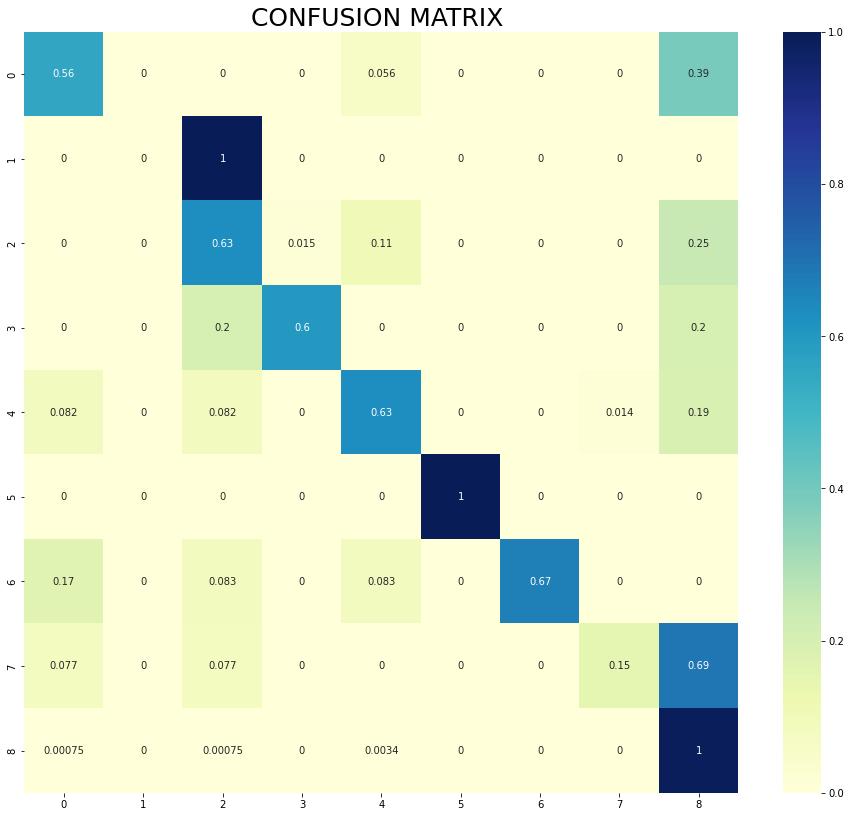

In [132]:
plt.figure(figsize=(16,14))
sns.heatmap(conf_mat, annot = True, cmap="YlGnBu")
plt.title("CONFUSION MATRIX ", fontsize=25)
plt.show()

In [129]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average = None)
print(f1)

[0.51282051 0.         0.69491525 0.66666667 0.67153285 1.
 0.8        0.25       0.988893  ]


augmentation이 잘 안된 모습.. 

In [133]:
y_pred1 = mymodel_withoutmax.predict(x_test)
y_test1 = y_test
y_pred1 = np.argmax(y_pred1, axis=1)
f2 = f1_score(y_test1, y_pred1, average = None )
print(f2)

[0.48780488 0.         0.58064516 0.5        0.37837838 1.
 0.69230769 0.         0.98135499]


##모델 비교

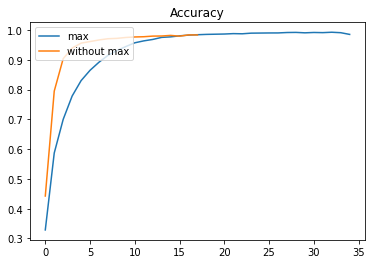

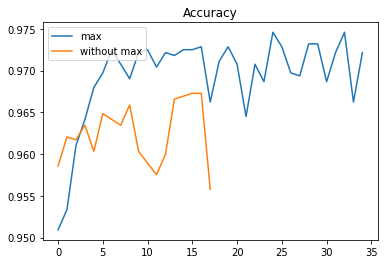

In [100]:
plt.plot(mymodel_hist.history['accuracy'])
plt.plot(mymodelwithoutmax_hist.history['accuracy'])
plt.title('Accuracy')
plt.legend(['max','without max'], loc='upper left')
plt.show()
plt.plot(mymodel_hist.history['val_accuracy'])
plt.plot(mymodelwithoutmax_hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['max','without max'], loc='upper left')
plt.show()

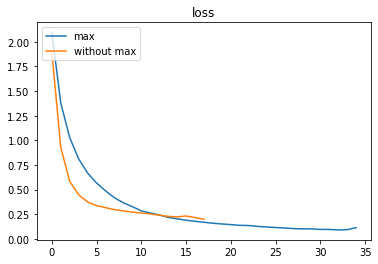

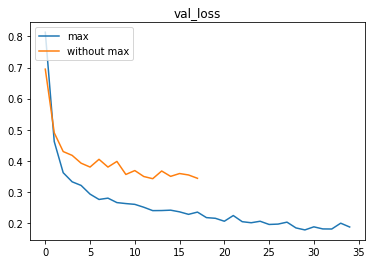

In [101]:
plt.plot(mymodel_hist.history['loss'])
plt.plot(mymodelwithoutmax_hist.history['loss'])
plt.title('loss')
plt.legend(['max','without max'], loc='upper left')
plt.show()
plt.plot(mymodel_hist.history['val_loss'])
plt.plot(mymodelwithoutmax_hist.history['val_loss'])
plt.title('val_loss')
plt.legend(['max','without max'], loc='upper left')
plt.show()

### Cross validate model

In [ ]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Class Activation Map Cross validation score : {:.4f}'.format(np.mean(results)))